## NREL National Solar Radiation Database (NSRDB) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point
from scipy.spatial import cKDTree

## Basic Usage

The NSRDB is provided in annual .h5 files and currently spans 1998-2018.  
Each year can be accessed from /nrel/nsrdb/nsrdb_${year}.h5

In [2]:
# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2012.h5", 'r')

## Datasets

In [3]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(17568, 2018392)

In [4]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 00:30:00',
               '2012-01-01 01:00:00', '2012-01-01 01:30:00',
               '2012-01-01 02:00:00', '2012-01-01 02:30:00',
               '2012-01-01 03:00:00', '2012-01-01 03:30:00',
               '2012-01-01 04:00:00', '2012-01-01 04:30:00',
               ...
               '2012-12-31 19:00:00', '2012-12-31 19:30:00',
               '2012-12-31 20:00:00', '2012-12-31 20:30:00',
               '2012-12-31 21:00:00', '2012-12-31 21:30:00',
               '2012-12-31 22:00:00', '2012-12-31 22:30:00',
               '2012-12-31 23:00:00', '2012-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17568, freq=None)

In [5]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [6]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 00:30:00',
               '2012-01-01 01:00:00', '2012-01-01 01:30:00',
               '2012-01-01 02:00:00', '2012-01-01 02:30:00',
               '2012-01-01 03:00:00', '2012-01-01 03:30:00',
               '2012-01-01 04:00:00', '2012-01-01 04:30:00',
               ...
               '2012-12-31 19:00:00', '2012-12-31 19:30:00',
               '2012-12-31 20:00:00', '2012-12-31 20:30:00',
               '2012-12-31 21:00:00', '2012-12-31 21:30:00',
               '2012-12-31 22:00:00', '2012-12-31 22:30:00',
               '2012-12-31 23:00:00', '2012-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17568, freq=None)

Extract indexes for a particular span of time:

In [7]:
march = time_index.month == 3
np.where(march)[0]

array([2880, 2881, 2882, ..., 4365, 4366, 4367])

Or a particular date:

In [8]:
timestep = np.where(time_index == '2012-07-04 00:00:00')[0][0]
timestep

8880

## Map Data

In [ ]:
# Extract coordinates (lat, lon)
print(dict(f['coordinates'].attrs))
coords = f['coordinates'][...]

In [ ]:
dset = f['ghi']
data = dset[timestep, ::100]   # extract every 10th location at a particular time

In [ ]:
df = pd.DataFrame() # Combine data with coordinates in a DataFrame
df['longitude'] = coords[::100, 1]
df['latitude'] = coords[::100, 0]
df['ghi'] = data / dset.attrs['psm_scale_factor'] # unscale dataset

In [ ]:
df.shape

In [ ]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [ ]:
# Full resolution subset of Colorado
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

In [ ]:
data = dset[timestep][CA.index]  # full-resolution subset
df = CA[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['psm_scale_factor']
df.shape

In [ ]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

## Nearest Timeseries for given Lat/Lon

In [9]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

dset_coords = f['coordinates'][...]
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

FortRoss = (38.51265, -123.24647)
FortRoss_idx = nearest_site(tree, FortRoss[0], FortRoss[1] )

print("Site index for Fort Ross: \t\t {}".format(FortRoss_idx))
print("Coordinates of Fort Ross: \t {}".format(FortRoss))
print("Coordinates of nearest point: \t {}".format(dset_coords[FortRoss_idx]))

Site index for Fort Ross: 		 131123
Coordinates of Fort Ross: 	 (38.51265, -123.24647)
Coordinates of nearest point: 	 [  38.53 -123.26]


In [10]:
# Get the entire 2012 timeseries data for a point in FR
%time tseries = dset[:, FortRoss_idx] / dset.attrs['psm_scale_factor']

CPU times: user 4.79 ms, sys: 2.19 ms, total: 6.98 ms
Wall time: 997 ms


In [11]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

17568

Text(0.5, 1.0, 'FR ghi in 2012')

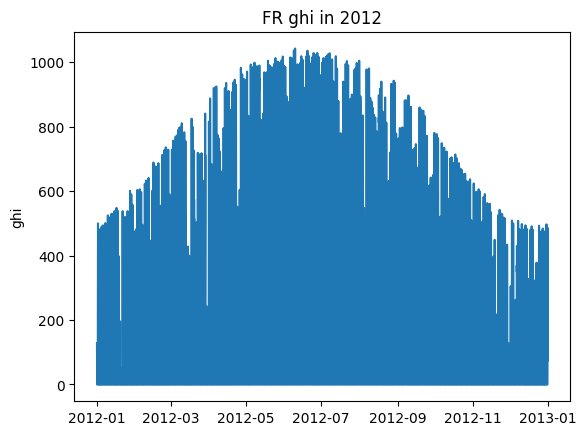

In [13]:
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title("FR ghi in 2012")

/var/folders/qc/5h73dwnj6d75cbb1b8b1r1f80000gn/T/ipykernel_28389/21510338.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


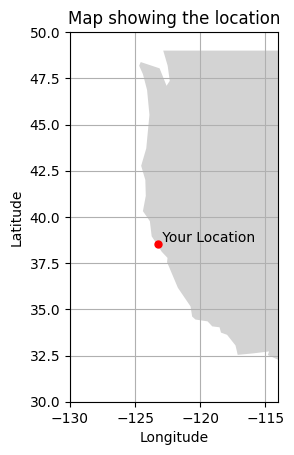

In [20]:

# Define the latitude and longitude
# lat, lon = 34.0522, -118.2437  # Example: Los Angeles, CA
lat, lon = FortRoss

# Load a map of the US
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_map = gdf[gdf.name == "United States of America"]

# Plot the map
fig, ax = plt.subplots()
us_map.plot(ax=ax, color='lightgrey')

# Adjust the plot limits to focus on California
# These limits can be adjusted to better frame California as needed
ax.set_xlim([-130, -114])
ax.set_ylim([30, 50])

# Plot the latitude and longitude as a point on the map
plt.plot(lon, lat, marker='o', color='red', markersize=5)
plt.text(lon, lat, ' Your Location', verticalalignment='bottom')

plt.title('Selected Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

## GHI Statistics

In [ ]:
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

In [ ]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI (W/m^2)")
plt.colorbar()